# Titanic survivor prediction

Hi, in this notebook we are going to explore, analyze and predict whether a passenger on the Titanic survived or not. First, we should start by downloading the data.

## Download the data

You can find the dataset [here](https://www.kaggle.com/c/titanic/data).

Now let's import the first necessary libraries.

## Importing the libaries

In [275]:
import math,time,datetime

import pandas as pd
import numpy as np
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
# Classifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection,preprocessing,metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# Warnings
import warnings
warnings.filterwarnings('ignore')

## Importing the data
Now we are good to import the dataset via pandas

In [276]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [277]:
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## Data desrciption

**Survival**: 0 = No, 1 = Yes

**pclass (Ticket class)**: 1 = 1st, 2 = 2nd, 3 = 3rd

**sex**: Sex

**Age**: Age in years

**sibsp**: number of siblings/spouses aboard the Titanic

**parch**: number of parents/children aboard the Titanic

**ticket**: Ticket number

**fare**: Passenger fare

**cabin**: Cabin number

**embarked**: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

Columns as described as shown above.

In [278]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Missing values

Now let's find out how many missing values and in which feature are there.

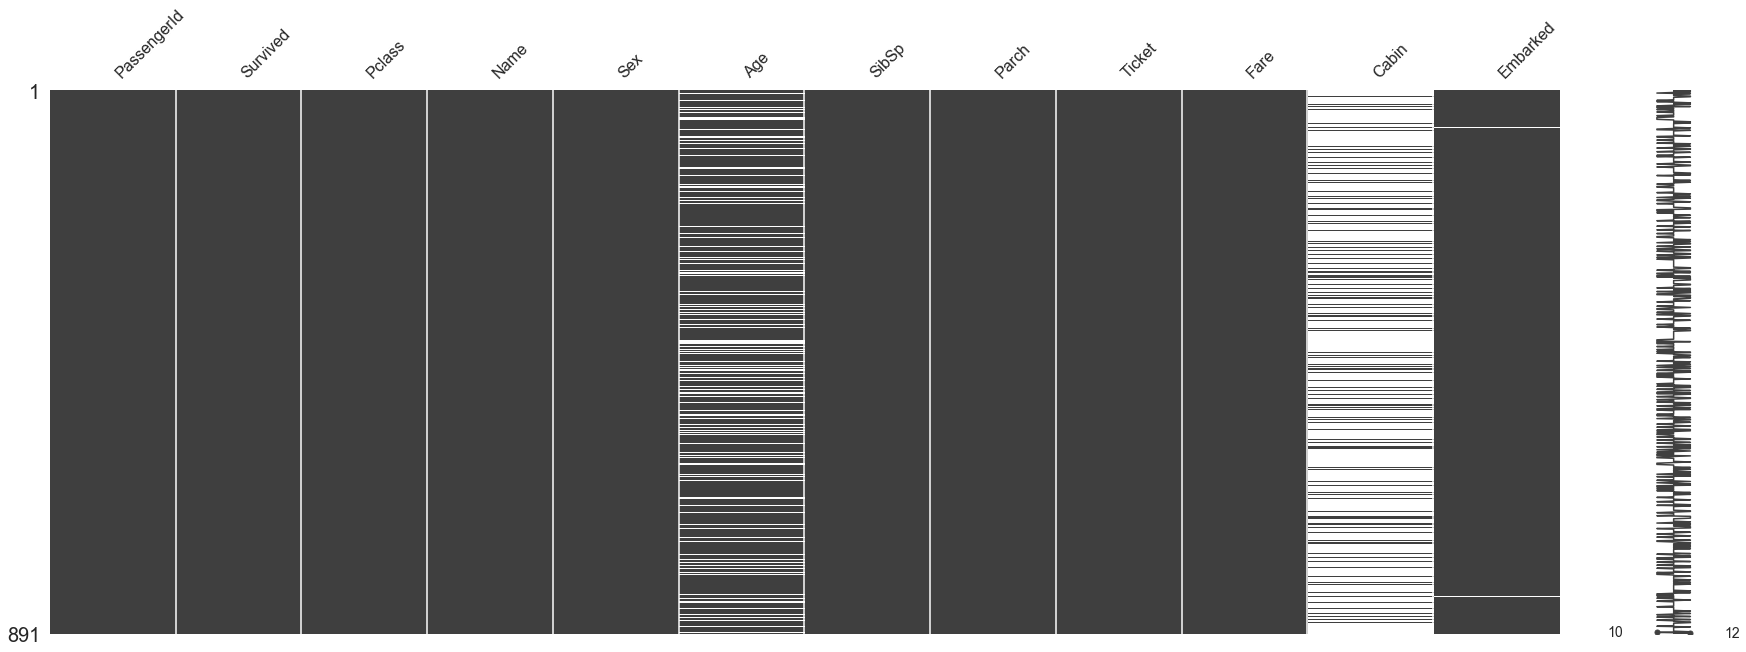

In [279]:
missingno.matrix(train,figsize=(30,10))

Therefore we can see that the features **Age** and **Cabin** will be pretty useless for further prediction so we will consider dropping them later.

Now let's see how many missing values are there exactly.

In [280]:
df_length = len(train)
print("Train total length: " +  str(df_length))
for i in train.columns:
    df_nans = df_length - train[i].value_counts().sum()
    print(i + ": " + str(df_nans))

Train total length: 891
PassengerId: 0
Survived: 0
Pclass: 0
Name: 0
Sex: 0
Age: 177
SibSp: 0
Parch: 0
Ticket: 0
Fare: 0
Cabin: 687
Embarked: 2


### Handling the missing data

#### Age

Now let's focus on how to solve the problem with the missing data in the feature **age**. As I showed earlier we have 177 times missing ages in the dataset. Which is almost a quarter! So we need to find a way to replace them. After brainstorming about this problem I came up with the following plan:

- 1. If the persons' sex is male and he has the word **Master** in his name we set the age to the average value of males under 21.
- 2. If the persons' sex is male and he has the word **Mr** in his name and travels alone his age is set to the average age of males with **Mr** in his name who travel alone. Else: The age is set to the average age of males with the word **Mr** in his name.
- 3. If the persons' sex is female and has **Miss** in her name her age is set to the average age of females under 21.
- 4. If the persons' sex is female and has **Mrs** in her name and travels alone her age is set to the average age of females who travel alone and have **Mrs** in her name. Else: The age is set to the average age of females with the word **Mrs** in her name.

I've come up with these ideas by executing the following:

In [281]:
train.loc[train['Age'] < 18]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.7000,G6,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.00,0,0,350406,7.8542,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.00,0,0,330923,8.0292,NaN,Q
24,25,0,3,"Palsson, Miss. Torborg Danira",female,8.00,3,1,349909,21.0750,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.00,1,0,2651,11.2417,NaN,C
43,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,C
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S


In [282]:
train.loc[(train['Age'] < 90) & (train['Sex'] == 'male') & train['Name'].str.contains('Master')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S
59,60,0,3,"Goodwin, Master. William Frederick",male,11.00,5,2,CA 2144,46.9000,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.9000,NaN,S
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
125,126,1,3,"Nicola-Yarred, Master. Elias",male,12.00,1,0,2651,11.2417,NaN,C
164,165,0,3,"Panula, Master. Eino Viljami",male,1.00,4,1,3101295,39.6875,NaN,S
165,166,1,3,"Goldsmith, Master. Frank John William ""Frankie""",male,9.00,0,2,363291,20.5250,NaN,S
171,172,0,3,"Rice, Master. Arthur",male,4.00,4,1,382652,29.1250,NaN,Q


In [283]:
train.loc[(train['Age'] < 21) & (train['Sex'] == 'male')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,NaN,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00,0,0,A/5. 2151,8.0500,NaN,S
16,17,0,3,"Rice, Master. Eugene",male,2.00,4,1,382652,29.1250,NaN,Q
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
50,51,0,3,"Panula, Master. Juha Niilo",male,7.00,4,1,3101295,39.6875,NaN,S
59,60,0,3,"Goodwin, Master. William Frederick",male,11.00,5,2,CA 2144,46.9000,NaN,S
63,64,0,3,"Skoog, Master. Harald",male,4.00,3,2,347088,27.9000,NaN,S
67,68,0,3,"Crease, Mr. Ernest James",male,19.00,0,0,S.P. 3464,8.1583,NaN,S
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
86,87,0,3,"Ford, Mr. William Neal",male,16.00,1,3,W./C. 6608,34.3750,NaN,S


In [284]:
train.loc[(train['Age'] > 21) & (train['Sex'] == 'female')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.4750,NaN,S
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,NaN,S


Alright now let's develop a method which replaces the NaN's with the age set by the rules before.

But first we need to fill the missing values(currently NaN) with 0's to replace them.

In [285]:
train.fillna(0,inplace=True)
test.fillna(0,inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


In [286]:
sum_male_under_21 = 0
sum_male_under_21_c = 0
sum_male_alone = 0
sum_male_alone_c = 0
sum_male_over_21 = 0
sum_male_over_21_c = 0

sum_female_under_21 = 0
sum_female_under_21_c = 0
sum_female_alone = 0
sum_female_alone_c = 0
sum_female_over_21 = 0
sum_female_over_21_c = 0


for i, row in train.iterrows():
    if train['Age'][i] != 0: 
        #male
        if train['Age'][i] < 21: 
            if train['Sex'][i] == 'male':
                sum_male_under_21 = sum_male_under_21 + train['Age'][i]
                sum_male_under_21_c = sum_male_under_21_c + 1
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'male':
                sum_male_over_21 = sum_male_over_21 + train['Age'][i]
                sum_male_over_21_c = sum_male_over_21_c + 1    
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'male':
                if train['SibSp'][i] == 0:
                    if train['Parch'][i] == 0:
                        sum_male_over_21 = sum_male_alone + train['Age'][i]
                        sum_male_over_21_c = sum_male_alone_c + 1
        #female
        if train['Age'][i] < 21: 
            if train['Sex'][i] == 'female':
                sum_female_under_21 = sum_female_under_21 + train['Age'][i]
                sum_female_under_21_c = sum_female_under_21_c + 1
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'female':
                sum_female_over_21 = sum_female_over_21 + train['Age'][i]
                sum_female_over_21_c = sum_female_over_21_c + 1    
        if train['Age'][i] >= 21: 
            if train['Sex'][i] == 'female':
                if train['SibSp'][i] == 0:
                    if train['Parch'][i] == 0:
                        sum_female_over_21 = sum_female_alone + train['Age'][i]
                        sum_female_over_21_c = sum_female_alone_c + 1
                        
                        
avg_male_under_21 = sum_male_under_21 / sum_male_under_21_c
avg_male_over_21 = sum_male_over_21 / sum_male_over_21_c
avg_male_alone = 0
avg_female_under_21 = sum_female_under_21 / sum_female_under_21_c
avg_female_over_21 = sum_female_over_21 / sum_female_over_21_c
avg_female_alone = 0

print(avg_male_under_21,avg_male_over_21,avg_male_alone,avg_female_under_21,avg_female_over_21,avg_female_alone,sep='\n')

13.302621359223302
32.0
0
11.883116883116884
30.5
0


Now let's fill in the matching **ages**:

In [287]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,0.0,1,2,W./C. 6607,23.45,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,0,Q


In [288]:
c = 0
while c < 2:
    if (c == 0):
        f = train
    if (c == 1):
        f = test
    for i, row in f.iterrows():
        if f['Age'][i] == 0: 
            #male
            if f['Age'][i] < 21: 
                if f['Sex'][i] == 'male':
                    f.loc[i,'Age'] = avg_male_under_21
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'male':
                    f.loc[i,'Age'] = avg_male_over_21
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'male':
                    if f['SibSp'][i] == 0:
                        if f['Parch'][i] == 0:
                            f.loc[i,'Age'] = avg_male_alone
            #female
            if f['Age'][i] < 21: 
                if f['Sex'][i] == 'female':
                    f.loc[i,'Age'] = avg_female_under_21
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'female':
                    f.loc[i,'Age'] = avg_female_over_21 
            if f['Age'][i] >= 21: 
                if f['Sex'][i] == 'female':
                    if f['SibSp'][i] == 0:
                        if f['Parch'][i] == 0:
                            f.loc[i,'Age'] = avg_female_alone
    c = c + 1                        

In [289]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.00,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,11.883117,1,2,W./C. 6607,23.45,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.000000,0,0,370376,7.75,0,Q


In [290]:
test.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,13.302621,0,0,A.5. 3236,8.0500,0,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,0,S
416,1308,3,"Ware, Mr. Frederick",male,13.302621,0,0,359309,8.0500,0,S
417,1309,3,"Peter, Master. Michael J",male,13.302621,1,1,2668,22.3583,0,C


As this table above shows the replacing successfully worked! :)

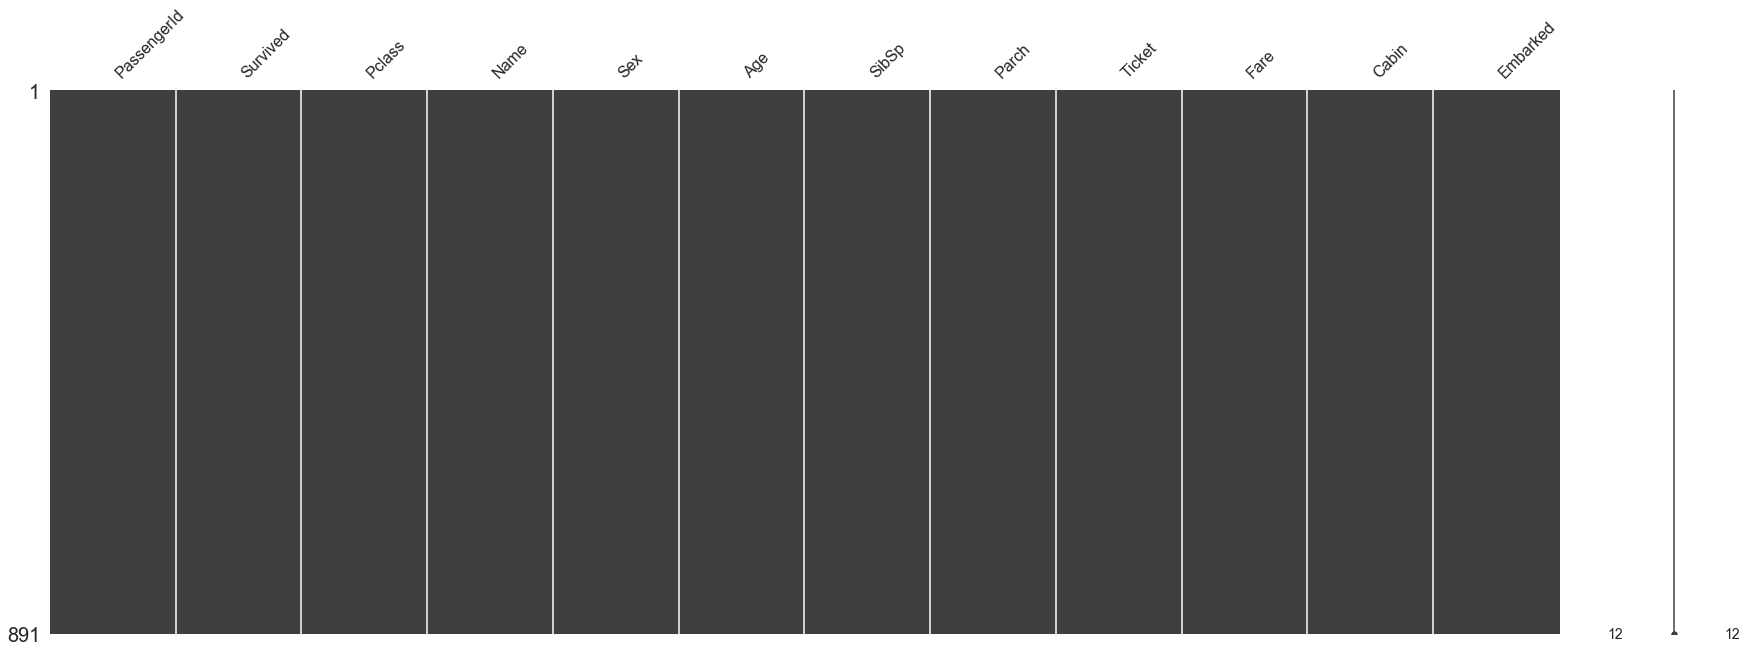

In [291]:
missingno.matrix(train,figsize=(30,10))

#### Cabin

Now let's drop the feature Cabin cause it has too many missing values.

In [292]:
train.drop(columns='Cabin',inplace=True)
test.drop(columns='Cabin',inplace=True)

In [293]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [294]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


#### Embarked

For the **Embarked** feature we know that there are only **2** rows where it is missing, so let's just drop them to fix that.

In [295]:
train.loc[train['Embarked'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,0


In [296]:
test.loc[train['Embarked'] == 0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,953,2,"McCrae, Mr. Arthur Gordon",male,32.0,0,0,237216,13.5,S


In [297]:
train.drop(index=[61,829],inplace=True)
train.loc[train['Embarked'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


## Analyse data

Before we start analyzing each feature on its own, we should start by finding out the data type of each feature:

In [298]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

We see that there are just a few features who aren't in the data type of a numerical value e.g. int or float. This is going to be a good thing for the feature encoding later on(Same goes for the test dataframe).

Now let's start analyzing the data, first let's start with

## Survived

0 = passenger not survived
1 = passenger survived

This is the variable we want our machine learning model to predict based off all the others.

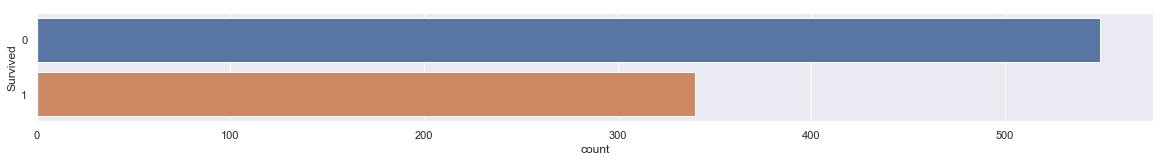

In [299]:
fig = plt.figure(figsize=(20,2))
sns.countplot(y='Survived',data=train)

In [300]:
len(train.loc[train['Survived'] == 1])

340

In [301]:
len(train.loc[train['Survived'] == 0])

549

In [302]:
len(train)

889

Therefore we can see that more than 500 people died on the Titanic and about 350 people survived the sinking.
So the probability that a randomly picked passenger survived the sinking is 340/889 so about **38%**.

## Pclass

Description: The ticket class of the passenger.
Key: 1=1st 2=2nd 3=3rd

We will look at the distribution of each feature first if we can to understand what kind of spread there is across the dataset.
For example, if there are values which are completely outside of the distribution, we may not want to include them in our model. So let's check that out.

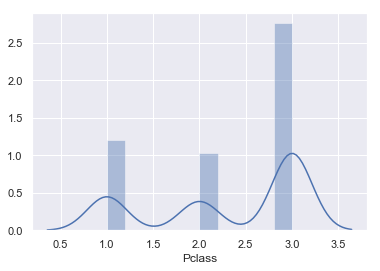

In [303]:
sns.distplot(train.Pclass)

We see that this is not really the case so we'll use this feature for our prediction later on.

## Name

We already know that everyone has a unique name so we could compare this to the passenger id. Also, we used this feature earlier to fill in the NaN's for the age feature. Although we won't use this feature for prediction later on because of the lack of importance for the prediction.

## Sex

Let's compare the distribution of the genders.

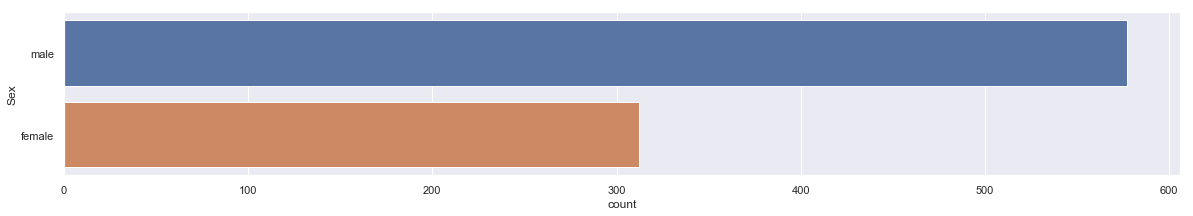

In [304]:
fig = plt.figure(figsize=(20,3))
sns.countplot(y='Sex',data=train)

Now let's check out how many of the male's and female's have survived. 

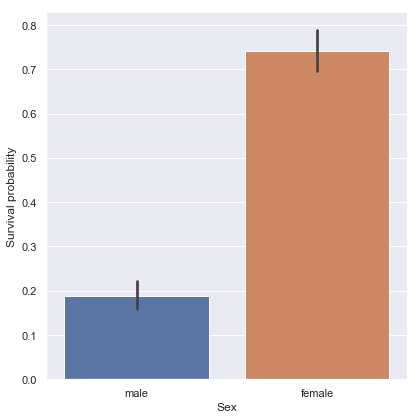

In [305]:
g = sns.catplot(x='Sex',y='Survived',data=train,height=6,kind='bar') 
g.set_ylabels('Survival probability')

So as we see the probability that a randomly picked passenger survived the Titanic is 4-times higher if the passenger is female.

## Age 

Now let's check how the different ages are spread in the dataset.

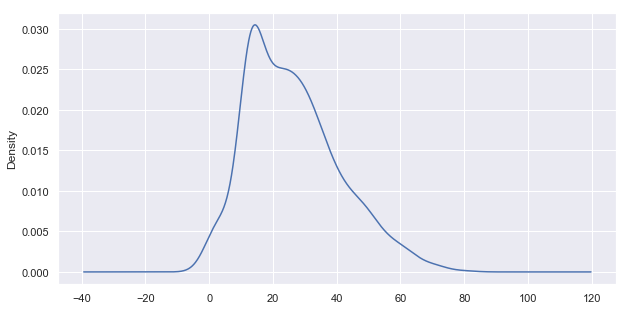

In [306]:
plt.figure(figsize=(10,5))
# plots a kernel density estimate of the subset of the 1st class passangers's age
train.Age.plot(kind='kde')    

In [307]:
train['Age'].sum() / len(train)

26.304274739425068

Therefore we know that the average age aboard the Titanic is about **26 years**.

Now let's find out how the probability to survive the sinking is with view on the different ages.

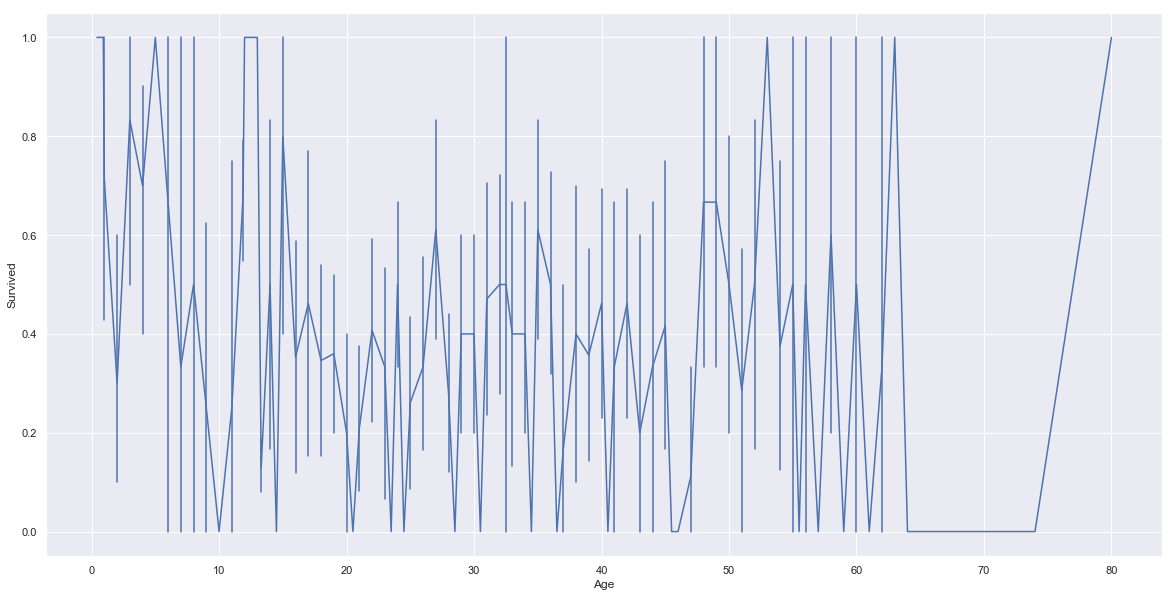

In [308]:
fig = plt.figure(figsize=(20,10))
sns.set(style='darkgrid')
sns.lineplot(x='Age',y='Survived',data=train,err_style="bars")

Out of this we can see that if a passenger is between 65 and 74 he's going to die during the sinking, this is the worst age of all! For the rest take a look at the chart yourself :)

## SibSp

Now let's check how many sibilings/spouses are aboard with the passenger.

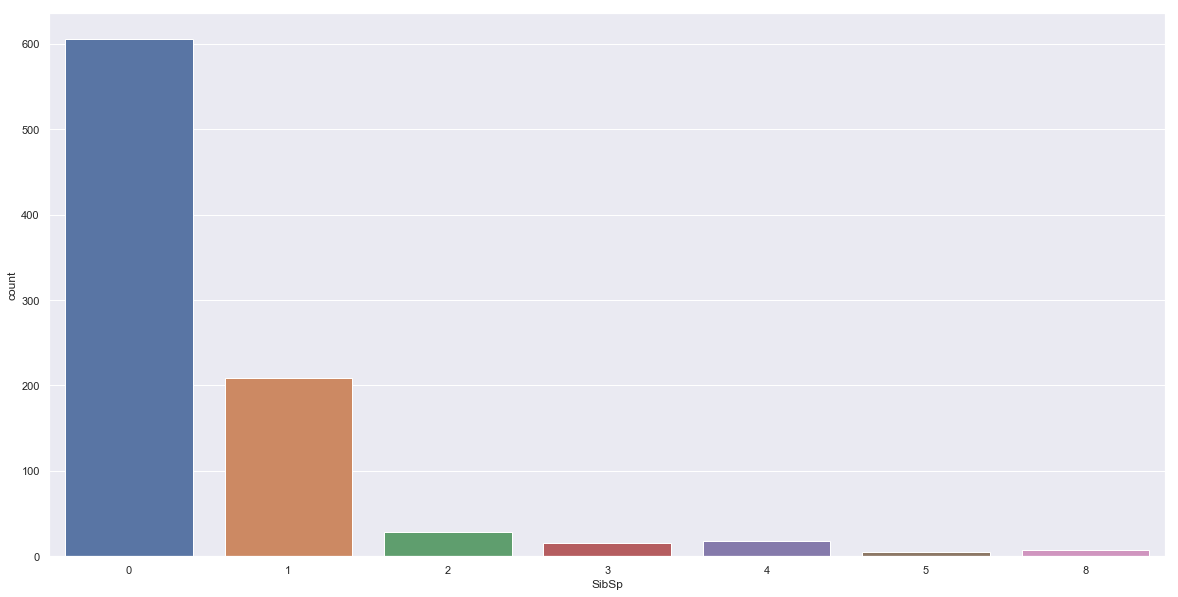

In [309]:
fig = plt.figure(figsize=(20,10))
g = sns.countplot(x='SibSp',data=train)

Therefore we can see that most passengers traveled alone.

## Parch

Now let's do the same as we did with the sibilings/spouses with parents/children aboard the Titanic.

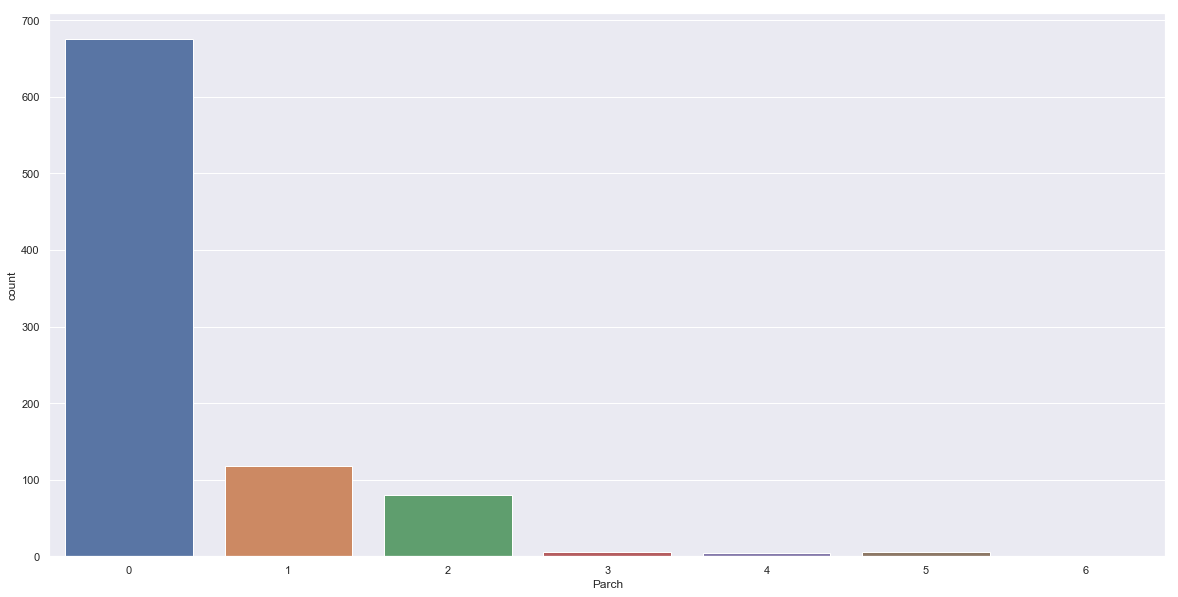

In [310]:
fig = plt.figure(figsize=(20,10))
g = sns.countplot(x='Parch',data=train)

## Ticket

As you've might observed earlier there are a **lot** of different ticket types:

In [311]:
train.Ticket.value_counts()

CA. 2343            7
1601                7
347082              7
347088              6
3101295             6
CA 2144             6
S.O.C. 14879        5
382652              5
113781              4
113760              4
4133                4
2666                4
W./C. 6608          4
PC 17757            4
19950               4
LINE                4
17421               4
347077              4
349909              4
13502               3
371110              3
C.A. 31921          3
SC/Paris 2123       3
363291              3
PC 17582            3
110413              3
PC 17755            3
PC 17572            3
PC 17760            3
35273               3
                   ..
248698              1
111428              1
3101277             1
PC 17612            1
240929              1
347062              1
SC/PARIS 2167       1
244270              1
345770              1
349215              1
371362              1
349207              1
19972               1
315153              1
C.A. 33111

So there are **680** unique ticket types. Wow! That is a lot, and really not easy to simplify in the feature encoding, later on, so we won't use this feature in the prediction later on.

## Fare

Description: How much the ticket cost for every individual passenger.

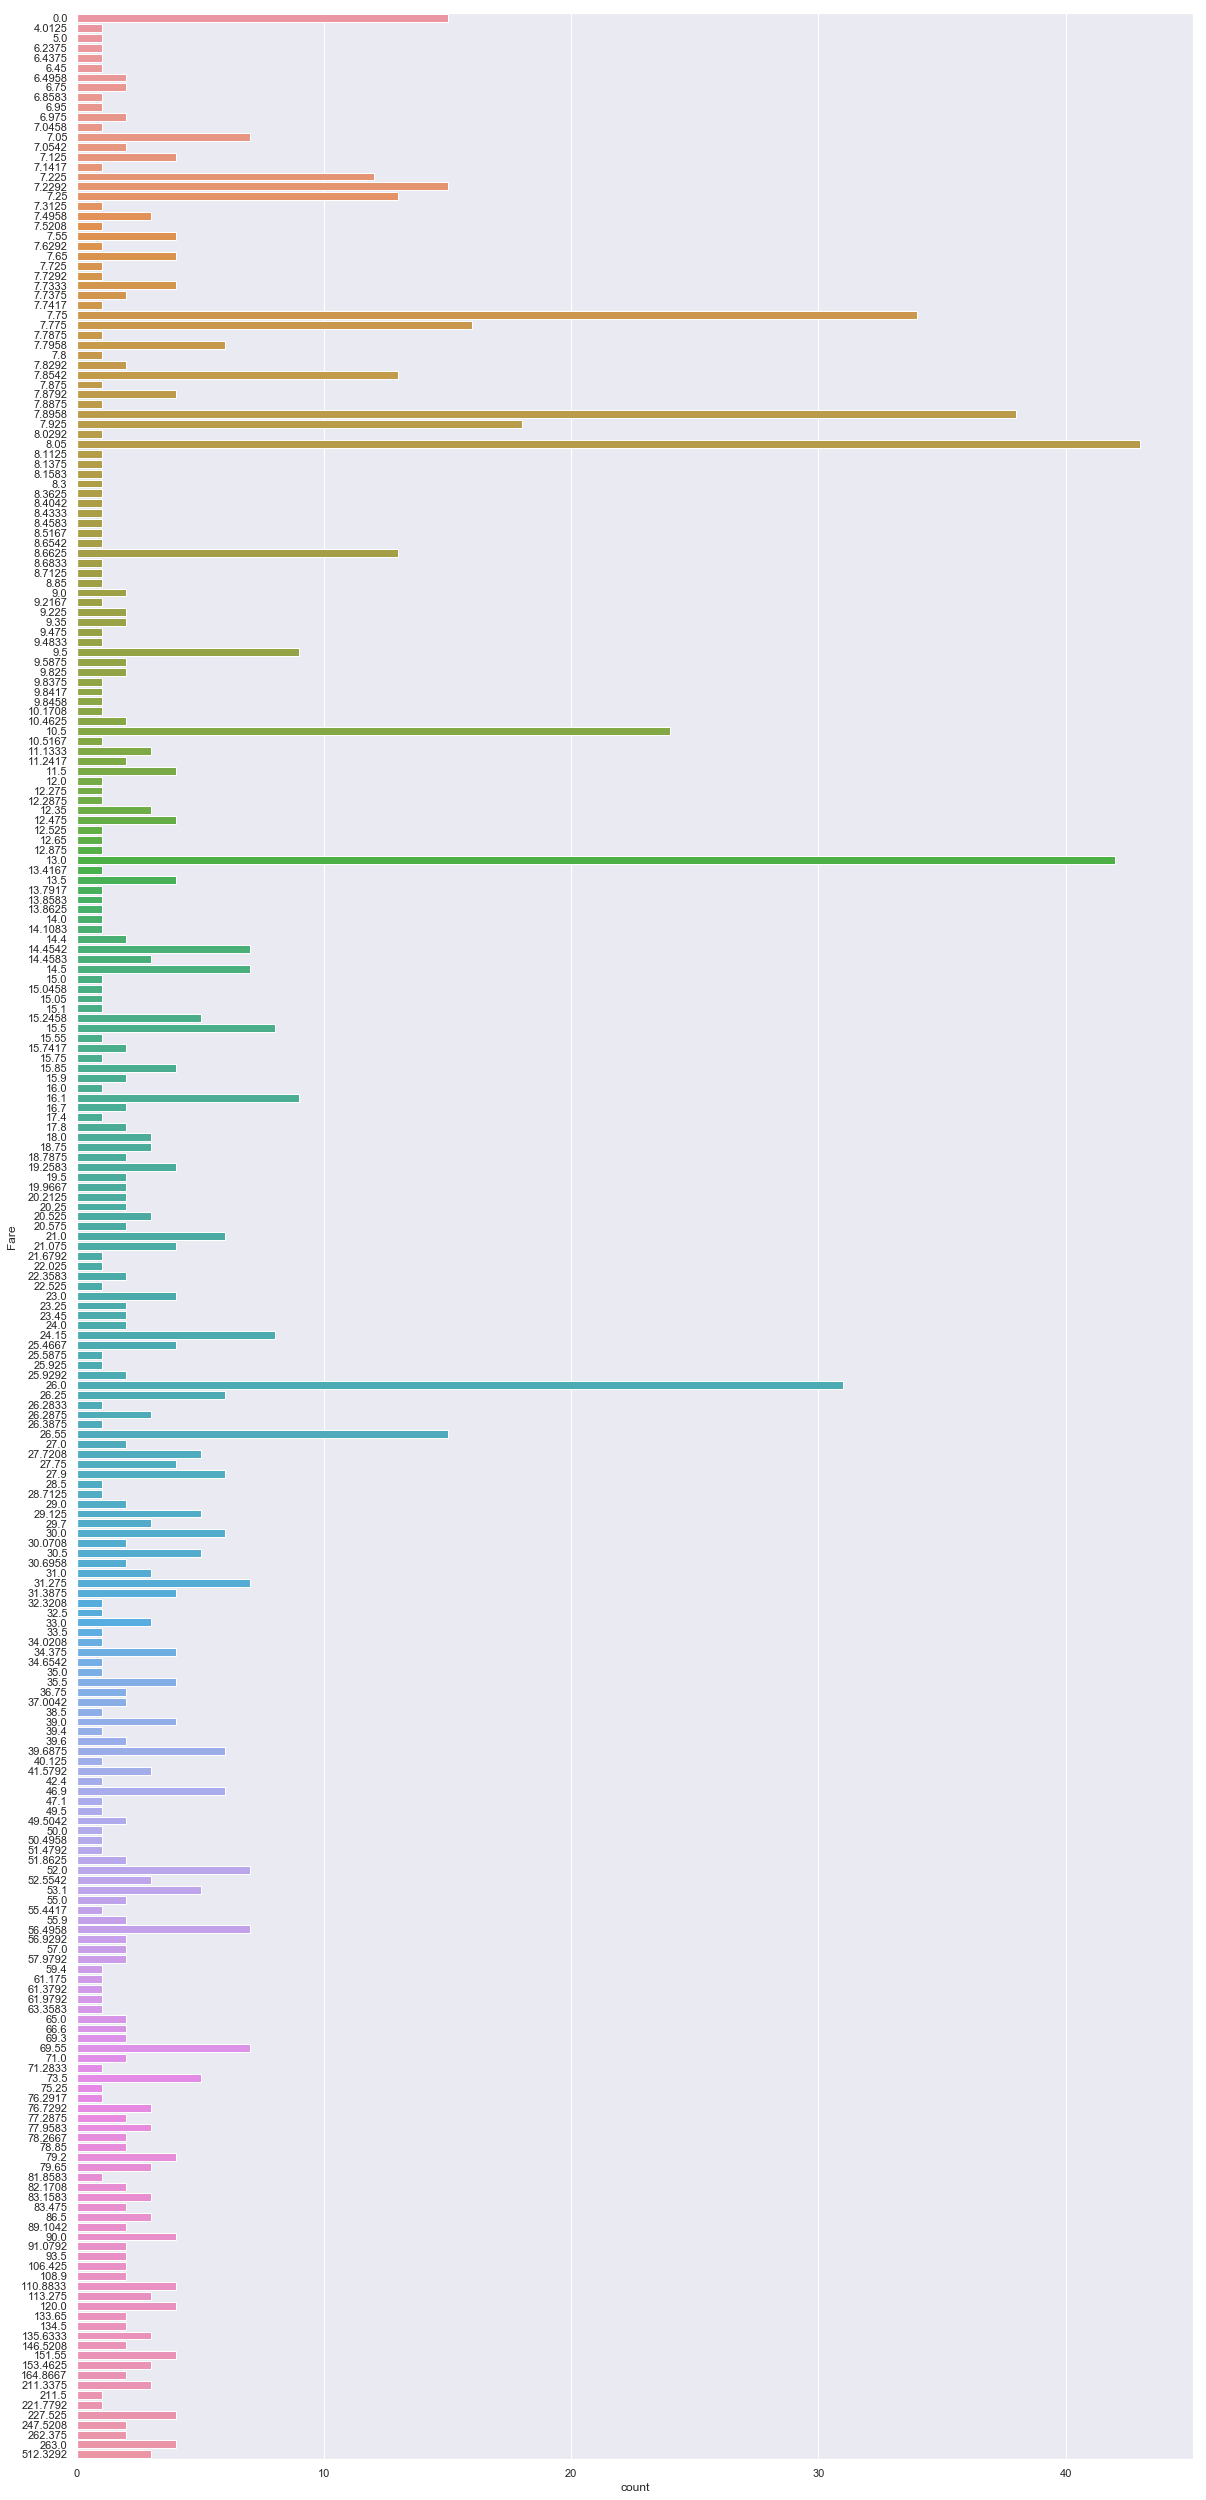

In [312]:
fig = plt.figure(figsize=(20,45))
sns.countplot(y='Fare',data=train)

Fun fact: This is the average ticket price for a fare on the Titanic.

In [313]:
train.Fare.sum() / len(train)

32.09668087739032

## Embarked

Description: Port's were the passengers had go on board of the Titanic.

Possible port's are: C = Cherbourg, Q = Queenstown, S = Southampton 

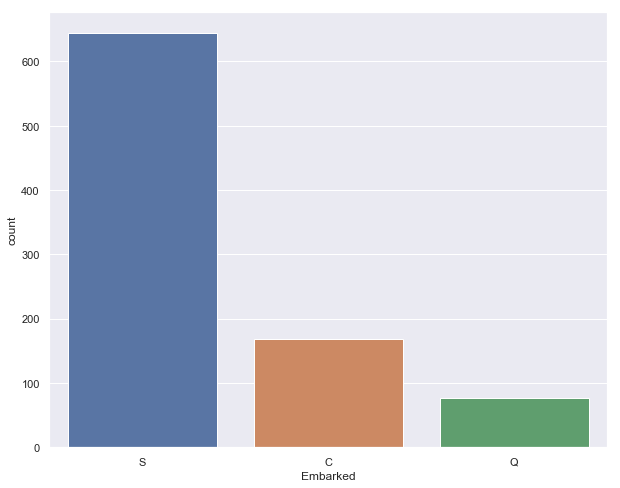

In [314]:
fig = plt.figure(figsize=(10,8))
sns.countplot(x='Embarked',data=train)

Therefore we can see that most passengers came onboard on the Titanic at the port of Southampton, so most passengers are from England.

## Feature Encoding

Now let's start encoding the features so that the ML algorithms can work with the dataset. First, let's see which features need to be encoded:

In [315]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

We need to encode all features who are **objects**. So, in this case, the following features: **Name**,**Sex**,**Ticket** and **Embarked**.

### Name

As we said earlier we won't use this feature due to lack of importance. So let's just drop it from the dataframe.

In [316]:
del train['Name']
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,female,35.0,1,0,113803,53.1000,S
4,5,0,3,male,35.0,0,0,373450,8.0500,S


In [317]:
del test['Name']
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,Q
1,893,3,female,47.0,1,0,363272,7.0000,S
2,894,2,male,62.0,0,0,240276,9.6875,Q
3,895,3,male,27.0,0,0,315154,8.6625,S
4,896,3,female,22.0,1,1,3101298,12.2875,S


### Sex

Next is the feature **sex**. There are only two possible outcomes for sex: male and female. We will encode them so that **0 = male** and **1 = female**.

In [318]:
c = 0
while c < 2:
    if (c == 0):
        f = train
    if (c == 1):
        f = test
    for i, rows in f.iterrows():
        if f['Sex'][i] == 'male':
            f.loc[i,'Sex'] = 0
        if f['Sex'][i] == 'female':
            f.loc[i,'Sex'] = 1
    c = c + 1        
        
train.head()        

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,1,35.0,1,0,113803,53.1000,S
4,5,0,3,0,35.0,0,0,373450,8.0500,S


In [319]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,0,34.5,0,0,330911,7.8292,Q
1,893,3,1,47.0,1,0,363272,7.0000,S
2,894,2,0,62.0,0,0,240276,9.6875,Q
3,895,3,0,27.0,0,0,315154,8.6625,S
4,896,3,1,22.0,1,1,3101298,12.2875,S


### Ticket

As we saw earlier there are **680** unique ticket types. This is way too much cause the dataset only contains 889 entries, so almost every passenger has a unique ticket. Therefore we just drop the feature.

In [320]:
del train['Ticket']
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,S
1,2,1,1,1,38.0,1,0,71.2833,C
2,3,1,3,1,26.0,0,0,7.9250,S
3,4,1,1,1,35.0,1,0,53.1000,S
4,5,0,3,0,35.0,0,0,8.0500,S


In [321]:
del test['Ticket']
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,Q
1,893,3,1,47.0,1,0,7.0000,S
2,894,2,0,62.0,0,0,9.6875,Q
3,895,3,0,27.0,0,0,8.6625,S
4,896,3,1,22.0,1,1,12.2875,S


### Embarked

So let's move on to the next feature. For **Embarked** we have three different outcomes: C = Cherbourg, Q = Queenstown, S = Southampton. So we will replace them with just the numbers **0 = Cherbourg**,**1 = Queenstown**,**2 = Southampton**.

In [322]:
c = 0
while c < 2:
    if (c == 0):
        f = train
    if (c == 1):
        f = test
    for i, rows in f.iterrows():
        if f['Embarked'][i] == 'S':
            f.loc[i,'Embarked'] = 2
        if f['Embarked'][i] == 'Q':
            f.loc[i,'Embarked'] = 1
        if f['Embarked'][i] == 'C':
            f.loc[i,'Embarked'] = 0
    c = c + 1    
        
train.head()  

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,2
1,2,1,1,1,38.0,1,0,71.2833,0
2,3,1,3,1,26.0,0,0,7.9250,2
3,4,1,1,1,35.0,1,0,53.1000,2
4,5,0,3,0,35.0,0,0,8.0500,2


## Building model

Now we are good to go to build our first model. However, before we can start let's separate the data.

In [323]:
y_train = train['Survived']
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [324]:
x_train = train
del x_train['Survived']
x_train.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,0,22.0,1,0,7.2500,2
1,2,1,1,38.0,1,0,71.2833,0
2,3,3,1,26.0,0,0,7.9250,2
3,4,1,1,35.0,1,0,53.1000,2
4,5,3,0,35.0,0,0,8.0500,2


### Define a function to fit ML algorithms
Since we will use a lot of different algorithms for the sklearn libary, they all take similiar input and give the same output. So to prevent writing code multiple times let's just define a function who does that for us:

In [325]:
#Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X, Y):
    
    test_size = 0.6
    seed = 7
    features_train, features_test, labels_train, labels_test = model_selection.train_test_split(X,Y,test_size=test_size,random_state=seed)
    
    cv = 10
    # One Pass
    model = algo.fit(features_train,labels_train)
    acc = round(model.score(features_test, labels_test) * 100, 2)
    
    # Cross Validation 
    test_pred = model_selection.cross_val_predict(algo, 
                                                  features_test, 
                                                  labels_test, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(labels_test, test_pred) * 100, 2)
    
    return acc,acc_cv,model

### Logistic Regression

In [326]:
start_time = time.time()
acc_log,acc_log_cv,model = fit_ml_algo(LogisticRegression(),
                                   x_train,
                                   y_train)
log_time = (time.time() - start_time)
log_model = model
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_log_cv)
print("Running time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 77.15
Accuracy CV 10-Fold: 80.52
Running time: 0:00:00.070410


### K-Nearest Neighbours

In [327]:
start_time = time.time()
acc_knn,acc_knn_cv,model = fit_ml_algo(KNeighborsClassifier(),
                                   x_train,
                                   y_train)
knn_model = model
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_knn_cv)
print("Running time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 62.17
Accuracy CV 10-Fold: 62.55
Running time: 0:00:00.055258


### Gaussian Naive Bayes

In [328]:
start_time = time.time()
acc_gaussian,acc_gaussian_cv,model = fit_ml_algo(GaussianNB(),
                                   x_train,
                                   y_train)
gaussian_model = model
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_gaussian_cv)
print("Running time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 77.9
Accuracy CV 10-Fold: 78.46
Running time: 0:00:00.032108


### Linear Support Vector Machines(Linear SVC)

In [329]:
start_time = time.time()
acc_linear_svc,acc_linear_svc_cv,model = fit_ml_algo(LinearSVC(),
                                   x_train,
                                   y_train)
acc_linear_svc_model = model
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_linear_svc_cv)
print("Running time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 48.88
Accuracy CV 10-Fold: 67.79
Running time: 0:00:00.118804


### Decision Tree

In [330]:
start_time = time.time()
acc_tree,acc_tree_cv,model = fit_ml_algo(DecisionTreeClassifier(),
                                   x_train,
                                   y_train)
tree_model = model
tree_time = (time.time() - start_time)
print("Accuracy: %s" % acc_tree)
print("Accuracy CV 10-Fold: %s" % acc_tree_cv)
print("Running time: %s" % datetime.timedelta(seconds=tree_time))

Accuracy: 72.85
Accuracy CV 10-Fold: 76.78
Running time: 0:00:00.036447


### Random Forest

In [331]:
start_time = time.time()
acc_forest,acc_forest_cv,model = fit_ml_algo(RandomForestClassifier(),
                                   x_train,
                                   y_train)
forest_model = model
forest_time = (time.time() - start_time)
print("Accuracy: %s" % acc_forest)
print("Accuracy CV 10-Fold: %s" % acc_forest_cv)
print("Running time: %s" % datetime.timedelta(seconds=forest_time))

Accuracy: 79.4
Accuracy CV 10-Fold: 81.09
Running time: 0:00:00.087067


## Model Results

Which model had the bets cross-validation accuracy?

**Note**: We care most about cross-validation metrics because the metrics we get from .fit() can randomly score higher than usual.

### Regular accuracy scores

In [332]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree','Random Forest'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian,  
        acc_linear_svc, 
        acc_tree,
        acc_forest
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Random Forest,79.40
2,Naive Bayes,77.90
1,Logistic Regression,77.15
4,Decision Tree,72.85
0,KNN,62.17
3,Linear SVC,48.88


### Cross validation scores

In [333]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Linear SVC', 
              'Decision Tree','Random Forest'],
    'Score': [
        acc_knn_cv,
        acc_log_cv,
        acc_gaussian_cv,
        acc_linear_svc_cv,
        acc_tree_cv,
        acc_forest_cv,
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
5,Random Forest,81.09
1,Logistic Regression,80.52
2,Naive Bayes,78.46
4,Decision Tree,76.78
3,Linear SVC,67.79
0,KNN,62.55


We can see from the tables, the Logistic Regression model had the best results. Getting close to 81% is pretty good considering guessing would result in about 50% accuracy (0 or 1).

We'll pay more attention to the cross-validation figure.

Cross-validation is more robust than just the *.fit()* models as it does multiple passes over the data instead of one.

Because the Logistic Regression model got the best results, we'll use it for the next steps.

The next step is to do a grid search on the 'Logistic Regression'.

## Grid Search

In [334]:
model = RandomForestClassifier()

params = {'n_estimators':np.arange(1,25,1),'criterion':['gini','entropy'],'min_samples_split':np.arange(2,10,1)}

start_time = time.time()
acc_rf,acc_rf_cv,model = fit_ml_algo(GridSearchCV(model,params),x_train,y_train)

forest_model = model
forest_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_rf_cv)
print("Running time: %s" % datetime.timedelta(seconds=forest_time))

Accuracy: 79.03
Accuracy CV 10-Fold: 82.4
Running time: 0:01:25.362998


In [335]:
model.best_params_

{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 7}

## Final algorithm

After trying out a couple of different algorithms and after doing GridSearch on the best one(RandomForest) we can build the final algorithm.

In [378]:
model = RandomForestClassifier()

start_time = time.time()
acc_forest,acc_forest_cv,model = fit_ml_algo(RandomForestClassifier(criterion='gini',
                                                                    min_samples_split=8,n_estimators=21),
                                                                    x_train,
                                                                    y_train)
forest_model = model
forest_time = (time.time() - start_time)
print("Accuracy: %s" % acc_forest)
print("Accuracy CV 10-Fold: %s" % acc_forest_cv)
print("Running time: %s" % datetime.timedelta(seconds=forest_time))

Accuracy: 82.58
Accuracy CV 10-Fold: 82.96
Running time: 0:00:00.190998


So as you can tell from above the RandomForest performs pretty good. It has almost 85% accuracy! Awesome. :)

## Submission

Now we are ready to do our kaggle submission, for that we just create a new dataframe with the **PassengerID** and **Survived/not Survived**.

In [379]:
submission_df = pd.DataFrame({'PassengerId':[],'Survived':[]},dtype=int)

In [380]:
submission_df['PassengerId'] = test['PassengerId']

In [381]:
liste = forest_model.predict(test)

submission_df['Survived'] = liste
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [382]:
submission_df.loc[submission_df['Survived'] == 1]

,PassengerId,Survived
8,900,1
12,904,1
14,906,1
15,907,1
19,911,1
21,913,1
22,914,1
23,915,1
24,916,1
26,918,1


In [383]:
submission_df.to_csv('submission.csv',index=False)
print('Submission ready!')

Submission ready!


In [384]:
submissions_check = pd.read_csv("submission.csv")
submissions_check

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
